In [4]:
import numpy as np 
import astropy.units as u
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
from feasibgs import forwardmodel as FM
# -- desi -- 
import desimodel.io
import desisim.simexp

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [8]:
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

waves = np.arange(wavemin, wavemax, 0.2) * u.angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, specsim_config_file='desi')
surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

3533.000000 < lambda < 9913.000000


In [10]:
desi = FM.SimulatorHacked(config, num_fibers=1, camera_output=True)

In [14]:
print np.arccos(2*0-1)/np.pi

1.0


In [18]:
print desi.atmosphere.moon.moon_phase
print desi.atmosphere.moon.moon_zenith
print desi.atmosphere.moon.separation_angle

1.0
100.0 deg
60.0 deg


In [49]:
desi.atmosphere.airmass

1.4

Text(0,0.5,'surface brightness')

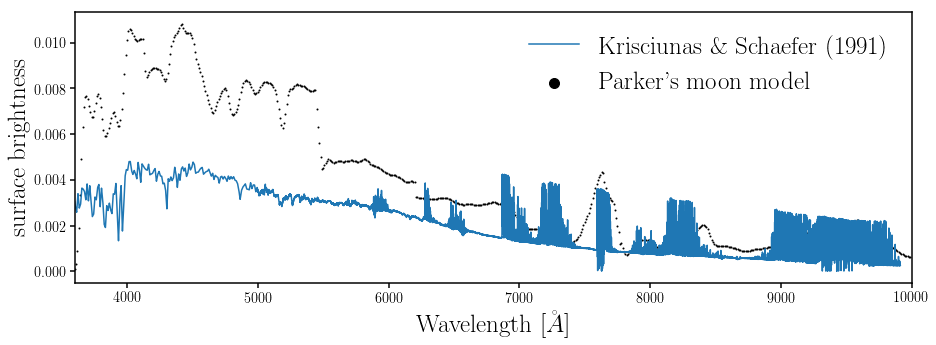

In [218]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
#moonfrac = 1.
airmass = 1.11
alt = 42.18
sep = 69.
ill = 0. 
moon_phase = np.arccos(2.*ill - 1)/np.pi
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = moon_phase #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg
sub.plot(waves, desi.atmosphere.moon.surface_brightness*1e17, label=r'Krisciunas $\&$ Schaefer (1991)')

theta_fid = (airmass, # airmass 
             10.94289, # ecl latitude
             41.60275, # galactic latitude
             198.8657, # galactic longitude
             4.86761390e+09, # tai
             -29.38102387, # sun altitude
             161.96666204, # sun separation
             moon_phase*np.pi, # moon phase
             ill, # moon ill
             sep, # moon sep
             alt # moon alt
            )
sky_spec = Sky.skySpec(*theta_fid)
w, Icont = sky_spec.get_Icontinuum() 
sub.scatter(np.array(sky_spec.coeffs['wl'])*10., (sky_spec._Imoon)/np.pi, 
            s=1, c='k', label=r"Parker's moon model")
sub.legend(loc='upper right', markerscale=10, fontsize=25)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3.6e3, 1e4])
sub.set_ylabel('surface brightness', fontsize=25)

Text(0,0.5,'surface brightness')

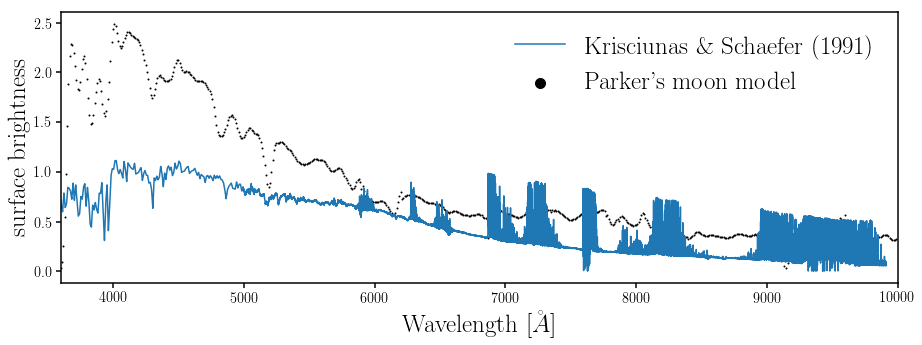

In [219]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
#moonfrac = 1.
airmass = 1.11
alt = 42.18
sep = 69.
ill = 0.42 
moon_phase = np.arccos(2.*ill - 1)/np.pi
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = moon_phase #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg
sub.plot(waves, desi.atmosphere.moon.surface_brightness*1e17, label=r'Krisciunas $\&$ Schaefer (1991)')

theta_fid = (airmass, # airmass 
             10.94289, # ecl latitude
             41.60275, # galactic latitude
             198.8657, # galactic longitude
             4.86761390e+09, # tai
             -29.38102387, # sun altitude
             161.96666204, # sun separation
             moon_phase*np.pi, # moon phase
             ill, # moon ill
             sep, # moon sep
             alt # moon alt
            )
sky_spec = Sky.skySpec(*theta_fid)
w, Icont = sky_spec.get_Icontinuum() 
sub.scatter(np.array(sky_spec.coeffs['wl'])*10., (sky_spec._Imoon + sky_spec.coeffs['c0'])/np.pi, 
            s=1, c='k', label=r"Parker's moon model")
sub.legend(loc='upper right', markerscale=10, fontsize=25)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3.6e3, 1e4])
sub.set_ylabel('surface brightness', fontsize=25)

In [98]:
import pandas as pd
from scipy.interpolate import interp1d
Results = pd.DataFrame.from_csv(''.join([UT.code_dir(), 'dat/sky/MoonResults.csv']))
Results.columns = ['wl','model','data_var','unexplained_var','X2','rX2','c0','c_am','tau','tau2','c_zodi','c_isl','sol','I', 't0','t1','t2','t3','t4','m0','m1','m2','m3','m4','m5','m6','feb','mar','apr','may','jun','jul','aug','sep','oct','nov', 'dec','c2','c3','c4','c5','c6']
MoonResults = Results[Results['model']=='moon']

#calculate albedo
albedo_file = ''.join([UT.code_dir(), 'dat/sky/albedo_constants.csv'])
albedo_table = pd.read_csv(albedo_file, delim_whitespace=True) 
AlbedoConstants = {}
for constant in list(albedo_table):
    line = interp1d(albedo_table['WAVELENGTH'],albedo_table[constant],bounds_error=False, fill_value=0)
    AlbedoConstants[constant] = line
    
def albedo(wl, moon_phase):
    p1 = 4.06054
    p2 = 12.8802
    p3 = -30.5858
    p4 = 16.7498
    A = []
    for i in range(4):
        A.append(AlbedoConstants['a%d'%i](wl)*(moon_phase**i))
    #for j in range(1,4):
    #    A.append(AlbedoConstants['b%s'%str(j)](wave)*(data_table['SOLAR_SELENO']**(2*j-1)))
    A.append(AlbedoConstants['d1'](wl)*np.exp(-moon_phase/p1))
    A.append(AlbedoConstants['d2'](wl)*np.exp(-moon_phase/p2))
    A.append(AlbedoConstants['d3'](wl)*np.cos((moon_phase-p3)/p4))
    #print AlbedoConstants['a%d'%i](wl)


    lnA = np.sum(A,axis=0)
    Albedo = np.exp(lnA)
    return Albedo

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
sort = np.argsort(np.array(MoonResults['wl']))
m0 = np.array(MoonResults['m0'])[sort]
m1 = np.array(MoonResults['m1'])[sort]
m2 = np.array(MoonResults['m2'])[sort]
m3 = np.array(MoonResults['m3'])[sort]
m4 = np.array(MoonResults['m4'])[sort]
m5 = np.array(MoonResults['m5'])[sort]
m6 = np.array(MoonResults['m6'])[sort]
c0 = np.array(MoonResults['c0'])[sort]
wl = np.array(MoonResults['wl'])[sort]

(0.0, 8.0)

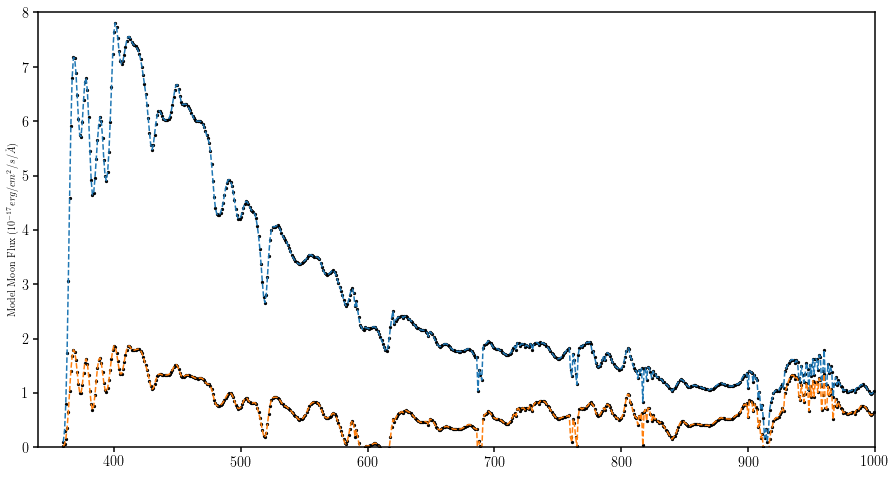

In [229]:

#moon1 = (m0*MM1['MOON_ALT']**2. + m1*MM1['MOON_ALT'] + m2*MM1['MOON_ILL']**2 + m3*MM1['MOON_ILL'] + m4*MM1["MOON_SEP"]**2. + m5*MM1['MOON_SEP'])*np.exp(-m6*MM1['AIRMASS'])*albedo(wl, MM1['MOON_PHASE'])+c0
fig, ax1 = plt.subplots(1,figsize = (15,8))
alt = 42.18
sep = 69.0
ill = 0.42
moon_phase = np.arccos(2.*ill - 1)
moon = (m0*alt**2. + m1*alt + m2*ill**2 + m3*ill + m4*sep**2. + m5*sep)*np.exp(-m6*1.11)*albedo(wl,moon_phase)+c0
plt.plot(wl, moon, c='C0', ls='--')
theta_fid = (1.11, # airmass 
             10.94289, # ecl latitude
             41.60275, # galactic latitude
             198.8657, # galactic longitude
             4.86761390e+09, # tai
             -29.38102387, # sun altitude
             161.96666204, # sun separation
             moon_phase, # moon phase
             ill, # moon ill
             sep, # moon sep
             alt # moon alt
            )
sky_spec = Sky.skySpec(*theta_fid)
w, Icont = sky_spec.get_Icontinuum() 
plt.scatter(np.array(sky_spec.coeffs['wl']), (sky_spec._Imoon + sky_spec.coeffs['c0']), 
            s=5, c='k')
sub.legend(loc='upper right', markerscale=10, fontsize=25)
alt = 30.27
sep = 37.08
ill = 0.27
moon_phase = np.arccos(2.*ill - 1)
moon = (m0*alt**2. + m1*alt + m2*ill**2 + m3*ill + m4*sep**2. + m5*sep)*np.exp(-m6*1.13)*albedo(wl,moon_phase)+c0
plt.plot(wl, moon, c='C1', ls='--')
theta_fid = (1.13, # airmass 
             10.94289, # ecl latitude
             41.60275, # galactic latitude
             198.8657, # galactic longitude
             4.86761390e+09, # tai
             -29.38102387, # sun altitude
             161.96666204, # sun separation
             moon_phase, # moon phase
             ill, # moon ill
             sep, # moon sep
             alt # moon alt
            )
sky_spec = Sky.skySpec(*theta_fid)
w, Icont = sky_spec.get_Icontinuum() 
plt.scatter(np.array(sky_spec.coeffs['wl']), np.array(sky_spec._Imoon + sky_spec.coeffs['c0']), 
            s=5, c='k')
ax1.set_ylabel('Model Moon Flux ($10^{-17} erg/cm^{2}/s/\AA$)')
ax1.set_xlim([340, 1e3])
ax1.set_ylim([0., 8.])